In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import add_path
from toolkit.paths import paths
from toolkit.pipeline.global_settings import GLOBAL_SETTINGS
from toolkit.pipeline.data_io import SessionDirectory
from toolkit.allen_helpers.location import StructureFinder, central_channel_in_structure

pd.set_option('display.max_columns', None)

### Config

Whether to overwrite data (probe info, LFP channels) with updated layer positions

In [2]:
overwrite_data = True

Setup

In [3]:
ecephys_structure_acronym = GLOBAL_SETTINGS['ecephys_structure_acronym']

# get sessions in data cache directory
data_dir = paths.PROCESSED_DATA_CACHE_DIR / ecephys_structure_acronym
session_list = [f.name for f in data_dir.iterdir() if f.is_dir()]

In [4]:
sf = StructureFinder(paths.REFERENCE_SPACE_CACHE_DIR, structure_acronym=ecephys_structure_acronym)

# Acronyms of layers from deep to superficial
layers = np.array(list(sf.layer_acronym_map.values()))
# layer colors for visualization
colors = plt.get_cmap('plasma', layers.size)(np.linspace(0, 1, layers.size))

### Load LFP channel data for sessions with CCF coordinates

In [5]:
lfp_channels = []

for session_id in session_list:
    session_dir = SessionDirectory(session_id, ecephys_structure_acronym)
    probe_info = session_dir.load_probe_info()
    if not session_dir.has_lfp_data or not probe_info['central_channels'] or probe_info.get('guess_layers', False):
        # skip if no lfp data, or no layers assigned, or layers assigned by guessing
        continue

    # load LFP channels inside the structure
    lfp_channel = session_dir.load_lfp_channels()
    lfp_channel = lfp_channel.loc[lfp_channel['inside_structure']]
    lfp_channels.append(lfp_channel)

### Estimate channel layer positions

In [6]:
vertical_positions = []
layer_indices = []  # layer indices range

for lfp_channel in lfp_channels:
    vertical_positions.append(lfp_channel['probe_vertical_position'].values)
    # from deep layers to superficial
    n_per_layer = [np.count_nonzero(lfp_channel['layer_acronym'] == layer) for layer in layers[::-1]]
    cumsum_layer = np.cumsum(np.insert(n_per_layer, 0, 0))
    # from superficial to deep
    layer_indices.append(np.column_stack([cumsum_layer[:-1], cumsum_layer[1:]])[::-1])
layer_indices = np.array(layer_indices) + [0, -1]  # include end index of each layer

In [7]:
vertical_position_portions = []  # vertical position portion (0 to 1) for each layer
boundary_portions = []  # layer boundary portion from superficial to deep

for i, lfp_channel in enumerate(lfp_channels):
    # get vertical position portions for each layer
    vertical_position_portion = np.linspace(0, 1, vertical_positions[i].size)
    vertical_position_portions.append(vertical_position_portion)
    # extend both ends of the portion range by 1 channel
    dv = vertical_position_portion[1]
    vertical_position_portion = np.hstack([-dv, vertical_position_portion, 1 + dv])
    # find layer boundary portion
    idx = layer_indices[i] + 1
    boundary_portion = (vertical_position_portion[idx[:-1, 0]] + vertical_position_portion[idx[1:, 1]]) / 2
    boundary_portions.append(boundary_portion)

# average layer boundary portion across sessions (decreasing from 1 to 0)
boundary_portion = np.mean(boundary_portions, axis=0)


#### Visualize layer positions

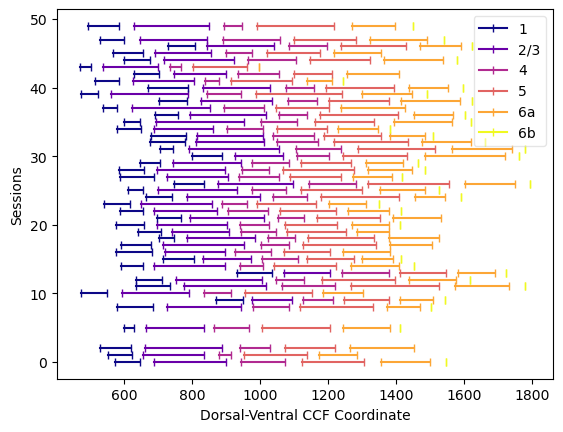

In [8]:
_, ax = plt.subplots(1, 1)

for i, lfp_channel in enumerate(lfp_channels):
    for j, layer in enumerate(layers):
        idx = layer_indices[i, j]
        if idx[0] > idx[1]:
            continue
        dv_ccf = lfp_channel['dorsal_ventral_ccf_coordinate'].values
        channel_range = dv_ccf[idx]
        ax.plot(channel_range, [i, i], color=colors[j], marker='|', label=layer)
ax.set_xlabel('Dorsal-Ventral CCF Coordinate')
ax.set_ylabel('Sessions')
ax.legend(layers, loc='upper right', framealpha=0.5)
plt.show()

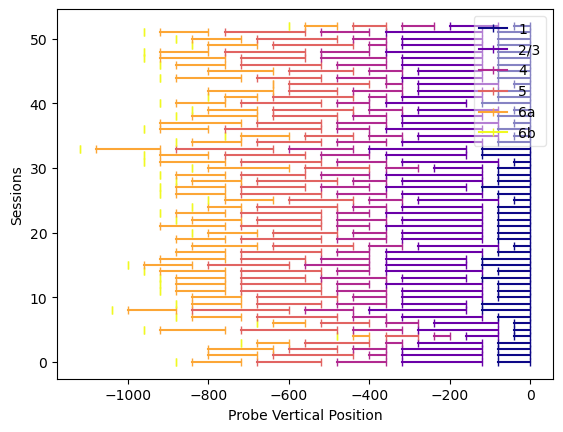

In [9]:
_, ax = plt.subplots(1, 1)

for i, lfp_channel in enumerate(lfp_channels):
    vertical_position = vertical_positions[i] - vertical_positions[i][-1]
    for j, layer in enumerate(layers):
        idx = layer_indices[i, j]
        if idx[0] > idx[1]:
            continue
        channel_range = vertical_position[idx]
        ax.plot(channel_range, [i, i], color=colors[j], marker='|', label=layer)
ax.set_xlabel('Probe Vertical Position')
ax.set_ylabel('Sessions')
ax.legend(layers, loc='upper right', framealpha=0.5)
plt.show()

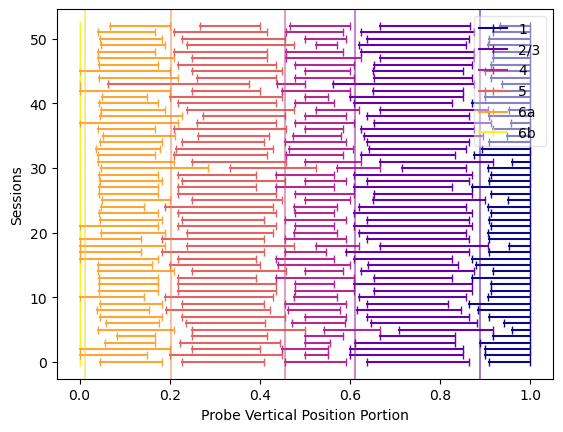

In [10]:
_, ax = plt.subplots(1, 1)

for i, lfp_channel in enumerate(lfp_channels):
    for j, layer in enumerate(layers):
        idx = layer_indices[i, j]
        if idx[0] > idx[1]:
            continue
        channel_range = vertical_position_portions[i][idx]
        ax.plot(channel_range, [i, i], color=colors[j], marker='|', label=layer)

for j in range(layers.size - 1):
    ax.axvline(boundary_portion[j], color=colors[j:j+2].mean(axis=0), alpha=0.5)

ax.set_xlabel('Probe Vertical Position Portion')
ax.set_ylabel('Sessions')
ax.legend(layers, loc='upper right', framealpha=0.5)
plt.show()

### Guess layers of LFP channels for sessions with no CCF coordinates

In [11]:
lfp_channels_ = []

for session_id in session_list:
    session_dir = SessionDirectory(session_id, ecephys_structure_acronym)
    probe_info = session_dir.load_probe_info()
    if not session_dir.has_lfp_data:  # no LFP data
        continue

    if probe_info['central_channels'] and not probe_info.get('guess_layers', False):
        # if layers assigned and not by guessing
        if overwrite_data:
            probe_info['guess_layers'] = False
            session_dir.save_probe_info(**probe_info)
        continue

    lfp_channel = session_dir.load_lfp_channels()
    # split layers from deep to superficial (portion increasing)
    split_layer_idx = (boundary_portion[::-1] * (len(lfp_channel) - 1)).astype(int) + 1
    split_layer_idx = np.hstack([0, split_layer_idx, len(lfp_channel)])
    channels = lfp_channel.index
    for i, layer in enumerate(layers[::-1]):
        lfp_channel.loc[channels[split_layer_idx[i]:split_layer_idx[i + 1]], 'layer_acronym'] = layer
    lfp_channel['inside_structure'] = True
    lfp_channels_.append(lfp_channel)

    if overwrite_data:
        central_channels = central_channel_in_structure(lfp_channel['layer_acronym'])
        central_channels = {s: int(lfp_channel.index[i]) for s, i in central_channels.items()}
        probe_info['central_channels'] = central_channels
        probe_info['guess_layers'] = True
        session_dir.save_probe_info(**probe_info)
        session_dir.save_lfp_channels(lfp_channel)

In [12]:
vertical_positions_ = []
layer_indices_ = []  # layer indices range
vertical_position_portions_ = []  # vertical position portion (0 to 1) for each layer

for lfp_channel in lfp_channels_:
    vertical_positions = lfp_channel['probe_vertical_position'].values
    vertical_positions_.append(vertical_positions)
    vertical_position_portions_.append(np.linspace(0, 1, vertical_positions.size))

    # from deep layers to superficial
    n_per_layer = [np.count_nonzero(lfp_channel['layer_acronym'] == layer) for layer in layers[::-1]]
    cumsum_layer = np.cumsum(np.insert(n_per_layer, 0, 0))
    # from superficial to deep
    layer_indices_.append(np.column_stack([cumsum_layer[:-1], cumsum_layer[1:]])[::-1])

if not len(lfp_channels_):
    raise ValueError("No session has LFP channels with missing CCF coordinates")

layer_indices_ = np.array(layer_indices_) + [0, -1]  # include end index of each layer

#### Visualize layer positions

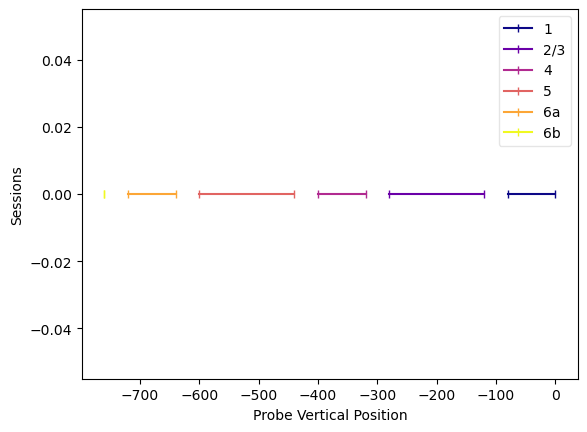

In [13]:
_, ax = plt.subplots(1, 1)

for i, lfp_channel in enumerate(lfp_channels_):
    vertical_position = vertical_positions_[i] - vertical_positions_[i][-1]
    for j, layer in enumerate(layers):
        idx = layer_indices_[i, j]
        if idx[0] > idx[1]:
            continue
        channel_range = vertical_position[idx]
        ax.plot(channel_range, [i, i], color=colors[j], marker='|', label=layer)
ax.set_xlabel('Probe Vertical Position')
ax.set_ylabel('Sessions')
ax.legend(layers, loc='upper right', framealpha=0.5)
plt.show()

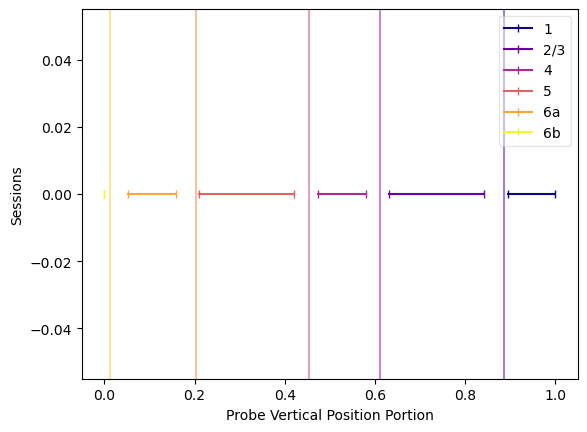

In [14]:
_, ax = plt.subplots(1, 1)

for i, lfp_channel in enumerate(lfp_channels_):
    for j, layer in enumerate(layers):
        idx = layer_indices_[i, j]
        if idx[0] > idx[1]:
            continue
        channel_range = vertical_position_portions_[i][idx]
        ax.plot(channel_range, [i, i], color=colors[j], marker='|', label=layer)

for j in range(layers.size - 1):
    ax.axvline(boundary_portion[j], color=colors[j:j+2].mean(axis=0), alpha=0.5)

ax.set_xlabel('Probe Vertical Position Portion')
ax.set_ylabel('Sessions')
ax.legend(layers, loc='upper right', framealpha=0.5)
plt.show()